In [1]:
import numpy as np
import sys
# sys.path.pop(2)
# sys.path.insert(1,'/home/zhanibek/.local/lib/python2.7/site-packages/cv2')
import cv2 
from cv2 import aruco
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from tqdm import tqdm_notebook

In [2]:
cv2.__version__

'3.3.1-dev'

### Functions

In [3]:
def showMarker(im):
    plt.imshow(im, interpolation='nearest', cmap='gray')

def read_image(fname):
    im = cv2.imread(fname)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return im

### Constants

In [4]:
base_dir = '../data/pose_estimation'

In [5]:
sqLength = 0.03677
mrkLegnth = 0.02959

In [6]:
'''
image 1: g_true = [[],
                   [],
                   [],
                   [0,0,0,1]]  # [R p]
                   
                   Euler angles, quaternion. Scipy -- how to compute Rotation matrices

'''

'\nimage 1: g_true = [[],\n                   [],\n                   [],\n                   [0,0,0,1]]  # [R p]\n                   \n                   Euler angles, quaternion. Scipy -- how to compute Rotation matrices\n\n'

(0, False)
(1, False)
(2, False)
(3, True)
(4, False)
(5, False)
(6, False)
(7, False)
(8, False)
(9, False)


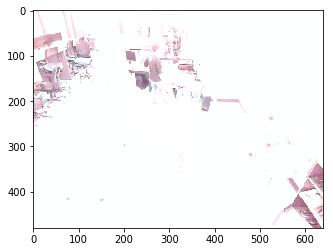

In [7]:
for i in range(10):
    vid = cv2.VideoCapture(i)
    res, im = vid.read()
    print(i, res)
    if res:
        plt.figure()
        im0 = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        plt.imshow(im0)
    vid.release()

In [8]:
res

False

In [ ]:
im0.shape

In [ ]:
im_partial = read_image(os.path.join(base_dir, 'charuco_pose_est', 'im0_partial_view.png'))
im_full = read_image(os.path.join(base_dir, 'charuco_pose_est', 'im0_full_view.png'))
im_cat = read_image(os.path.join(base_dir, 'charuco_pose_est', 'cat.png'))

In [ ]:
# cv2.imwrite(os.path.join(base_dir, 'charuco_pose_est', 'im0_partial_view.png'), im0)

### Charuco Board for Calibration

In [ ]:

aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)
calib_board = aruco.CharucoBoard_create(5, 7, sqLength, mrkLegnth, aruco_dict)
imboard = calib_board.draw((1000, 1400))

# cv2.imwrite(os.path.join(base_dir, "charuco_calibration.tiff"), imboard)

fig = plt.figure(figsize=(5,7))
showMarker(imboard)
plt.show()


### Charuco Board for Detection 1

In [ ]:
sqLen = 0.0644
mrklen = 0.04865 
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)
board1 = aruco.CharucoBoard_create(3, 4, sqLen, mrklen, aruco_dict)
imboard1 = board1.draw((3000, 4000))

# cv2.imwrite(os.path.join(base_dir, "charuco_detection_1.tiff"), imboard)

fig = plt.figure(figsize=(5,7))
showMarker(imboard1)
plt.show()


### Charuco Board for Detection 2

In [ ]:
sep2 = 0.02274
mrklen2 = 0.11376 
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)
board2 = aruco.GridBoard_create(1, 2, mrklen2, sep2, aruco_dict, 11)
# board2.ids = np.array([[11],[15]])
imboard = board2.draw((1000, 2000))

cv2.imwrite(os.path.join(base_dir, "charuco_detection_2.tiff"), imboard)

fig = plt.figure(figsize=(5,7))
showMarker(imboard)
plt.show()


In [ ]:
im0.shape

In [ ]:
board2.

In [ ]:
board2 = aruco.GridBoard_create

In [ ]:
board1 = aruco.Board_create

### Playing with Dictionaries

In [ ]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)
aruco_dict1 = aruco.custom_dictionary(16, 32, 0)

board = aruco.CharucoBoard_create(5, 7, 1, .8, aruco_dict)
imboard = board.draw((1000, 1400))

plt.figure(figsize=(5,7))
# plt.imshow(imboard, cmap = mpl.cm.gray, interpolation = "nearest")
showMarker(imboard)
plt.show()

# Calibrate

In [ ]:
datadir = "/home/zhanibek/catkin_ws/src/smart_tray/data/pose_estimation/calibration/logitech_t1/images/"
images = np.array([datadir + f for f in os.listdir(datadir) if f.endswith(".png") ])
order = np.argsort([int(p.split('/')[-1].split("_")[1].split("_")[0]) for p in images])
images = images[order]
len(images)

In [ ]:
images

In [ ]:
im = read_image(images[20])
plt.figure()
plt.imshow(im)
#ax.axis('off')
plt.show()

In [ ]:
class Calibrate_Camera:
    """Calibrate an individual camera"""
    def __init__(self, board):
#         self.dictionary = aruco.Dictionary_get(aruco.DICT_6X6_250)
#         self.row = 7  # horizontal
#         self.col = 5  # vertical
#         self.sqr = 1  # solid black squares
#         self.mrk = 0.8 # markers, must be smaller than squares
#         self.board = aruco.CharucoBoard_create(
#             self.col,self.row,
#             self.sqr,
#             self.mrk,
#             self.dictionary)
        self.board = board
        self.dictionary = self.board.dictionary

    def calculateReprojectionError(self, imgpoints, objpoints, rvecs, tvecs, mtx, dist):
        """
        imgpts: features found in image, (num_imgs, 2)
        objpts: calibration known features in 3d, (num_imgs, 3)
        """
        imgpoints = [c.reshape(-1,2) for c in imgpoints]
        mean_error = 0
        for i in range(len(objpoints)):
            imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
            imgpoints2 = imgpoints2.reshape(-1,2)

            # if not all markers were found, then the norm below will fail
            if len(imgpoints[i]) != len(imgpoints2):
                continue
                
            error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
            mean_error += error

        total_error = mean_error/len(objpoints)
        return total_error

    def calibrate(self, images):
        corners_all = []  # corners in all images
        ids_all = []  # ids found in all images
        image_size = None

#         images = glob.glob('./calib_images/*.jpg')

        for imname in tqdm_notebook(images):

            img = cv2.imread(imname)

            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
              
            corners, ids, rejectedImgPts = aruco.detectMarkers(gray, self.dictionary)
            
            # if ids were found, then
            if ids is not None and len(ids) > 0:
                ret, ch_corners, ch_ids = aruco.interpolateCornersCharuco(
                    corners, ids, gray, self.board)

                corners_all.append(ch_corners)
                ids_all.append(ch_ids)

        image_size = gray.shape[::-1]

        # Make sure at least one image was found
        if len(images) < 1:
            #Calibration failed because there were no images, warn the user
            print("Calibration was unsuccessful. No images of charucoboards were found. Add images of charucoboards and use or alter the naming conventions used in this file.")
            # Exit for failure
            exit()

        rms, cameraMatrix, distCoeffs, rvecs, tvecs = aruco.calibrateCameraCharuco(
            corners_all, ids_all, self.board, image_size, None, None)

        h, w = self.board.chessboardCorners.shape
        objpts = [self.board.chessboardCorners.reshape((h,1,3)) for c in corners_all]
        imgpts = corners_all
        
        rep_error = self.calculateReprojectionError(imgpts, objpts, rvecs, tvecs, cameraMatrix, distCoeffs)
        
        cam_cal_data = {
            'cameraMatrix': cameraMatrix,
            'distCoeffs': distCoeffs,
            'rotationVector': rvecs,
            'translationVector': tvecs,
            'reprojectionError': rep_error,
            'rms': rms
        }

        return cam_cal_data

In [ ]:
calib = Calibrate_Camera(calib_board)

In [ ]:
%time cam_cal_data = calib.calibrate(images)

#### Visualize Calibration

In [ ]:
ind = 0
img = read_image(images[ind])
plt.imshow(img)
images[ind]

In [ ]:
a,b,c = aruco.detectMarkers(img, calib_board.dictionary)

In [ ]:
plt.figure(figsize=(10,15))
plt.imshow(aruco.drawDetectedMarkers(img, c))

In [ ]:
len(cam_cal_data['rotationVector']), cam_cal_data['rotationVector'][ind].shape

In [ ]:
plt.imshow(aruco.drawAxis(img.copy(), cam_cal_data['cameraMatrix'], cam_cal_data['distCoeffs'],
          cam_cal_data['rotationVector'][ind], cam_cal_data['translationVector'][ind], 0.09))

In [ ]:
cam_cal_data

## Pose Estimation

In [ ]:
cam_cal_data.keys()

In [ ]:
camera_matrix = cam_cal_data['cameraMatrix']
dist_coeffs = cam_cal_data['distCoeffs']

#### Estimate Pose Board

In [ ]:
showMarker(board1.draw((200,200)))

In [ ]:
frame = im_cat.copy()
corners, ids, rejectedImgPoints = aruco.detectMarkers(frame, board1.dictionary)
retval,rvec,tvec = aruco.estimatePoseBoard( corners, ids, board1, camera_matrix, dist_coeffs, None, None, False )
# frame = aruco.drawAxis( frame, camera_matrix, dist_coeffs, rvec, tvec, mrklen )
# frame = aruco.drawDetectedMarkers( frame, corners, ids )


In [ ]:
np.isn

In [ ]:
frame = aruco.drawDetectedCornersCharuco

In [ ]:
plt.imshow(frame)

In [ ]:
board1.

#### Draw coordinate frame of every marker

In [ ]:
aruco.estimatePoseSingleMarkers?

In [ ]:
mrklen = 0.04865 
frame = im_full.copy()

corners, ids, rejectedImgPoints = aruco.detectMarkers(frame, board1.dictionary)

retval,rvec,tvec = aruco.estimatePoseSingleMarkers( corners, mrklen, camera_matrix, dist_coeffs, None, None, False )

frame = aruco.drawDetectedMarkers( frame, corners, ids )

for ind in range(min(len(tvec), len(rvec))):
    frame = aruco.drawAxis( frame, camera_matrix, dist_coeffs, rvec[ind], tvec[ind], mrklen )


In [ ]:
length_of_axis = 0.1
imaxis = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

for i in range(len(tvec)):
    imaxis = aruco.drawAxis(imaxis, camera_matrix, dist_coeffs, rvec[i], tvec[i], length_of_axis)

In [ ]:
plt.imshow(imaxis)

#### estimatePoseCharucoBoard 

In [ ]:
frame = im_full.copy()
corners, ids, rejectedImgPoints = aruco.detectMarkers(frame, board1.dictionary, camera_matrix, dist_coeffs)
corners, ids, rjcorners, recids = aruco.refineDetectedMarkers(frame, board1, corners, ids, rejectedImgPoints,
                                                             camera_matrix, dist_coeffs)

ret, ch_corners, ch_ids = aruco.interpolateCornersCharuco(corners, ids, frame, board1)

retval,rvec,tvec = aruco.estimatePoseCharucoBoard(ch_corners, ch_ids, board1, camera_matrix, dist_coeffs, None,None, False)


frame = aruco.drawAxis( frame, camera_matrix, dist_coeffs, rvec, tvec, mrklen )
frame = aruco.drawDetectedMarkers( frame, corners, ids )
frame = aruco.drawDetectedCornersCharuco(frame, ch_corners, ch_ids)

In [ ]:
plt.imshow(frame)

In [ ]:
aruco.interpolateCornersCharuco?

In [ ]:
aruco.detectMarkers?

In [ ]:
len(corners)

In [ ]:
np.array([1,2,3]) != None

In [ ]:
type(rvec)==np.ndarray

In [ ]:
all(None)

In [ ]:
tvec

In [ ]:
help(aruco.CharucoBoard_create)

In [ ]:
help(aruco.estimatePoseCharucoBoard)

In [ ]:
pt = np.array([[0,10],[0,10],[0,10]])
pt[2]

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(pt[0],pt[1],pt[2], MarkerSize=3)

In [ ]:
board_corners = [np.array([[0.09,0.01,0.0],[0.09,0.09,0.],[0.01,0.09,0.],[0.01,0.01,0.]],dtype=np.float32),
 np.array([[0.09,0.10,0.01],[0.09,0.10,0.09],[0.01,0.10,0.09],[0.01,0.10,0.01]],dtype=np.float32),
 np.array([[0.09,0.0,0.09],[0.09,0.0,0.01],[0.01,0.0,0.01],[0.01,0.0,0.09]],dtype=np.float32),
 np.array([[0.09,0.09,0.10],[0.09,0.01,0.10],[0.01,0.01,0.10],[0.01,0.09,0.10]],dtype=np.float32)]
board_ids = np.array( [[0],[10],[14],[12]], dtype=np.int32)
board = aruco.Board_create( board_corners,
 aruco.getPredefinedDictionary(aruco.DICT_6X6_250),
 board_ids )

In [ ]:
board_corners

In [ ]:
board_corners[0][:,0]

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
col = ['blue', 'red', 'black', 'yellow']
for ind in range(0,4):
    x = np.array(board_corners[ind][:,0]).flatten()
    y = np.array(board_corners[ind][:,1]).flatten()
    z = np.array(board_corners[ind][:,2]).flatten()
    ax.scatter(x,y,z, c = col[ind])

### 3D board

In [ ]:
mlen = 0.11367
x1_off = -0.18
y1_off = -0.158
z1_off = -0.024

x2_off = 0.074
y2_off = -0.029
z2_off = 0.
board_corners = [
    np.array([[x1_off, y1_off, z1_off], #1
              [mlen+x1_off, y1_off, z1_off],
              [mlen+x1_off, y1_off, -mlen+z1_off],
              [x1_off, y1_off, -mlen+z1_off]], dtype=np.float32),
    
    np.array([[x2_off, y2_off, z2_off],
              [mlen+x2_off, y2_off, z2_off],
              [mlen+x2_off, -mlen+y2_off, z2_off],
              [x2_off, -mlen+y2_off, z2_off]], dtype=np.float32)]
              
board_ids = np.array( [[11],[12]], dtype=np.int32)
board = aruco.Board_create(board_corners, aruco_dict, board_ids)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
col = ['blue', 'red', 'black', 'yellow']
for ind in range(0,2):
    x = np.array(board_corners[ind][:,0]).flatten()
    y = np.array(board_corners[ind][:,1]).flatten()
    z = np.array(board_corners[ind][:,2]).flatten()
    ax.scatter(x,y,z, c = col[ind])

In [ ]:
aruco.estimatePoseSingleMarkers?

In [ ]:
aruco.drawDetectedMarkers?